In [1]:
#import dependencies
import json
import requests
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import sqlite3


In [2]:
#url data was extracted from
url = "http://hotline.whalemuseum.org/api.json?&limit=1000&page="
page = 1

In [3]:
#loop to create one big file with all the records since the webpage limits to 1000 results
json = []

for page in range (1,20):
    query = url + str(page)
    response = requests.get(query)
    response_json = response.json()
    json.append(response_json)

In [4]:
#creates a dataframe with all of the records from the data above
i=0
for i in range (0,19): 
    if i == 0:
        df = pd.DataFrame.from_dict(json_normalize(json[i]), orient = 'columns')
    else: 
        df2 = pd.DataFrame.from_dict(json_normalize(json[i]), orient = 'columns')
        df = df.append(df2)

In [5]:
#resets the index so it doesn't start over with every new page
df = df.reindex()


In [6]:
#converts the zulu time to PST where the sightings occur
df["sighted_at"] = pd.DatetimeIndex(df["sighted_at"]).tz_convert('US/Pacific')


In [7]:
#creates additional time/date columns to filter and create various views of the data
df["date"] = df["sighted_at"].dt.strftime('%m/%d/%Y')
df["time"]=pd.DatetimeIndex(df["sighted_at"]).time
df["month"]=pd.DatetimeIndex(df["sighted_at"]).month
df["year"]=pd.DatetimeIndex(df["sighted_at"]).year
df["hour"]=pd.DatetimeIndex(df["sighted_at"]).hour
df["year_month"]=pd.to_datetime(df["sighted_at"]).dt.to_period('M')


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [8]:
#gets rid of the unnecessary columns
df = df.drop(columns =['url', 'quantity', 'created_at', 'updated_at' ])

In [9]:
#transforms the year_month column to a string
df['year_month']=df['year_month'].astype(str)

In [10]:
# #creates the connection to the database and copies the the database created and recreates it with a primary key
# conn = sqlite3.connect("whale_watching.sqlite")
# c = conn.cursor()

# df.to_sql("Whales",conn,schema=None,if_exists='replace',index=False, index_label=None, chunksize=None, dtype=None)


In [11]:
# #connect to the database


# c.executescript('''
#     PRAGMA foreign_keys=off;
    
#     BEGIN TRANSACTION;
    
#     ALTER TABLE "Whales" RENAME TO old_table;

#     /*create a new table with the same column names and types while
#     defining a primary key for the desired column*/
#     CREATE TABLE whale_table (id TEXT PRIMARY KEY NOT NULL,
#                             species TEXT, description TEXT, latitude DOUBLE , longitude DOUBLE, location TEXT,
#        sighted_at TEXT, orca_type TEXt, orca_pod TEXT, date TEXT, time TEXT, month INT, year INT, hour INT,
#        year_month TEXT);

#     INSERT INTO whale_table SELECT id, species, description, latitude, longitude, location,
#        sighted_at,orca_type, orca_pod, date, time, month, year, hour,
#        year_month FROM old_table;

#     DROP TABLE old_table;
#     COMMIT TRANSACTION;

#     PRAGMA foreign_keys=on;''')



In [12]:
# data = pd.read_sql("SELECT * FROM whale_table", conn )
# data.head()

In [13]:
# # reflect an existing database into a new model
# Base = automap_base()
# #Base = declarative_base()
# engine = create_engine("sqlite:///whale_watching.sqlite")
# # reflect the tables
# Base.prepare(engine, reflect = True)

In [14]:
# Base.classes.keys()

In [15]:
# #inspect the database
# inspector = inspect(engine)
# inspector.get_table_names()


In [16]:
# # Get a list of column names and types
# columns_s = inspector.get_columns('Whales')
# for c in columns_s:
#     print(c['name'], c['type'])

In [17]:
# c.execute("DROP TABLE Whales")
# conn.commit()

In [18]:
# #close out the connection
# c.close()
# conn.close()

In [19]:
#groupby to determine the count of sightings at each location
locations = df.groupby(['location'])['id'].count()
print(locations)

location
                               171
Alberni-Clayoquot A, BC, CA      3
Alberni-Clayoquot C, BC, CA      1
Alberni-Clayoquot F, BC, CA      1
Allyn-Grapeview, WA, US          2
                              ... 
Watsonville, CA, US              1
West Vancouver, BC, CA           2
Westport, CA, US                 1
Westport, WA, US                 1
Whatcom County, WA, US          26
Name: id, Length: 133, dtype: int64


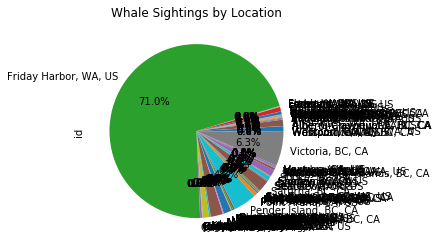

In [20]:
#creates an ugly pie chart of the locations.  71% of the sightings were at the same location and there are too many locations to map
locations.plot(kind = "pie", autopct ="%1.1f%%")
plt.title("Whale Sightings by Location")
plt.show()

Text(0.5, 1.0, 'Whale Sightings by Month')

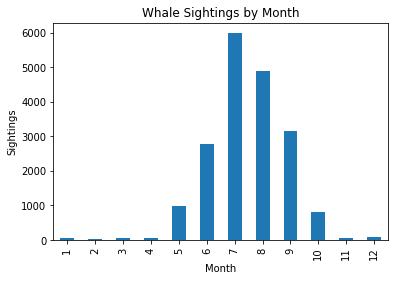

In [21]:
#creates a bar graph of the # of sightings per month
month = df.groupby(["month"])["id"].count()
month.plot(kind="bar")
plt.ylabel("Sightings")
plt.xlabel("Month")
plt.title("Whale Sightings by Month")

Text(0.5, 1.0, 'Whale Sightings by Pod')

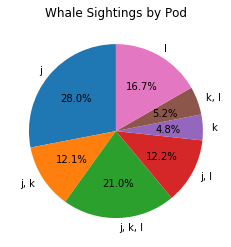

In [22]:
#creates a pie chart of the various pod sightings
pods = df.groupby(["orca_pod"])["id"].count()
pods.plot(kind="pie", autopct="%1.1f%%", startangle = 90)
plt.ylabel("")
plt.title("Whale Sightings by Pod")

Text(0.5, 1.0, 'Whale Sightings by Time of Day')

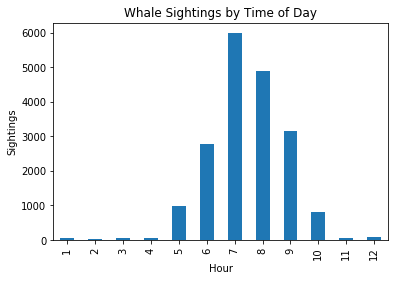

In [23]:
#creates a bar graph of the # of sightings by time of day
hour = df.groupby(["hour"])["id"].count()
month.plot(kind="bar")
plt.ylabel("Sightings")
plt.xlabel("Hour")
plt.title("Whale Sightings by Time of Day")

In [24]:
species = df.groupby(["species"])["id"].count()
species

species
atlantic white-sided dolphin        1
dall's porpoise                    10
gray whale                         26
harbor porpoise                     5
harbor seal                         3
humpback                            3
humpback whale                     41
minke whale                        35
northern elephant seal              1
orca                            18775
pacific white-sided dolphin         2
sea otter                           1
steller sea lion                    9
Name: id, dtype: int64

In [26]:
type = df.groupby(["orca_type"])["id"].count()
type

orca_type
offshore               141
southern resident    15722
transient              317
unknown               2600
Name: id, dtype: int64